#Business Understanding

We are downloading and saving the dataset from the API (give api reference etc.) and saving it in dataset.csv

In [1]:
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Data Understanding

In [2]:
df = pd.read_csv("Halifax_County_Water_Quality_Data_20240319.csv")

In [3]:
df.dtypes

WATERBODY             object
STATION               object
LEASE                float64
LATITUDE             float64
LONGITUDE            float64
DEPLOYMENT_PERIOD     object
TIMESTAMP             object
SENSOR                object
DEPTH                float64
VARIABLE              object
VALUE                float64
UNITS                 object
MOORING               object
dtype: object

In [5]:
import pandas as pd

df = pd.read_csv("Halifax_County_Water_Quality_Data_20240319.csv")

In [6]:
df

,WATERBODY,STATION,LEASE,LATITUDE,LONGITUDE,DEPLOYMENT_PERIOD,TIMESTAMP,SENSOR,DEPTH,VARIABLE,VALUE,UNITS,MOORING
0,Beaver Harbour,Beaver Point,NaN,44.877610,-62.39922,2018-Feb-28 to 2018-Sep-13,2018/02/28 05:09:00 PM,aquaMeasure-670380,2.0,Temperature,1.37,degrees Celsius,fixed
1,Beaver Harbour,Beaver Point,NaN,44.877610,-62.39922,2018-Feb-28 to 2018-Sep-13,2018/02/28 05:19:00 PM,aquaMeasure-670380,2.0,Temperature,1.37,degrees Celsius,fixed
2,Beaver Harbour,Beaver Point,NaN,44.877610,-62.39922,2018-Feb-28 to 2018-Sep-13,2018/02/28 05:29:00 PM,aquaMeasure-670380,2.0,Temperature,1.37,degrees Celsius,fixed
3,Beaver Harbour,Beaver Point,NaN,44.877610,-62.39922,2018-Feb-28 to 2018-Sep-13,2018/02/28 05:40:00 PM,aquaMeasure-670380,2.0,Temperature,1.37,degrees Celsius,fixed
4,Beaver Harbour,Beaver Point,NaN,44.877610,-62.39922,2018-Feb-28 to 2018-Sep-13,2018/02/28 05:50:00 PM,aquaMeasure-670380,2.0,Temperature,1.35,degrees Celsius,fixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809942,Spry Bay,Spry Harbour,NaN,44.817926,-62.61883,2021-Aug-09 to 2022-Aug-16,2022/08/16 12:00:00 PM,VR2AR-547086,12.0,Temperature,10.70,degrees Celsius,fixed
3809943,Spry Bay,Spry Harbour,NaN,44.817926,-62.61883,2021-Aug-09 to 2022-Aug-16,2022/08/16 01:00:00 PM,VR2AR-547086,12.0,Temperature,9.00,degrees Celsius,fixed
3809944,Spry Bay,Spry Harbour,NaN,44.817926,-62.61883,2021-Aug-09 to 2022-Aug-16,2022/08/16 02:00:00 PM,VR2AR-547086,12.0,Temperature,9.30,degrees Celsius,fixed
3809945,Spry Bay,Spry Harbour,NaN,44.817926,-62.61883,2021-Aug-09 to 2022-Aug-16,2022/08/16 03:00:00 PM,VR2AR-547086,12.0,Temperature,9.90,degrees Celsius,fixed


In [7]:
df['UNITS'].value_counts()

UNITS
degrees Celsius       3200156
percent saturation     558429
mg/L                    51362
Name: count, dtype: int64

In [8]:
df = df[df['UNITS'] != 'mg/L']

In [7]:
# df.drop(['LEASE', 'DEPLOYMENT_PERIOD', 'UNITS', 'MOORING'], axis=1, inplace=True)

In [9]:
pivot_df = df.pivot_table(
    index=["WATERBODY", "STATION", "LATITUDE", "LONGITUDE", "TIMESTAMP", "SENSOR"],
    columns="VARIABLE",
    values="VALUE",
    aggfunc='first'  # Assumes at most one measurement per VARIABLE type for each timestamp
).reset_index()

In [10]:
pivot_df

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
0,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:30:00 PM,HOBO-20291431,NaN,0.715
1,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:30:00 PM,VR2AR-547111,NaN,0.000
2,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:31:00 PM,VR2AR-547111,NaN,0.000
3,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:32:00 PM,VR2AR-547111,NaN,0.000
4,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:33:00 PM,VR2AR-547111,NaN,0.000
...,...,...,...,...,...,...,...,...
3466500,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:53:00 PM,aquaMeasure-670371,NaN,2.590
3466501,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:55:00 AM,aquaMeasure-670371,108.3,NaN
3466502,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:56:00 AM,aquaMeasure-670370,NaN,2.630
3466503,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:58:00 PM,aquaMeasure-670371,104.0,NaN


In [11]:
df_cleaned = pivot_df.dropna(subset=["Temperature", "Dissolved Oxygen"])

In [12]:
df_cleaned

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
47031,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:14:00 PM,aquaMeasure-675016,98.1,11.61
47045,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:24:00 PM,aquaMeasure-675016,98.3,11.59
47059,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:34:00 PM,aquaMeasure-675016,98.1,11.57
47071,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:44:00 PM,aquaMeasure-675016,98.3,11.59
47085,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:54:00 PM,aquaMeasure-675016,98.3,11.59
...,...,...,...,...,...,...,...,...
3423817,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/24 12:47:00 AM,aquaMeasure-670371,101.4,1.75
3423826,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/24 12:57:00 AM,aquaMeasure-670371,101.7,1.73
3423842,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/25 01:12:00 AM,aquaMeasure-670371,102.3,1.61
3423995,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/25 04:05:00 AM,aquaMeasure-670371,102.5,1.53


In [14]:
df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])
import warnings
warnings.filterwarnings('ignore')

C:\Users\Rashik\AppData\Local\Temp\ipykernel_40172\612178918.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])
C:\Users\Rashik\AppData\Local\Temp\ipykernel_40172\612178918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])


In [15]:
df_sorted = df_cleaned.sort_values(by='TIMESTAMP')


In [16]:
df_sorted

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
2568752,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:01:00,aquaMeasure-670352,108.0,1.80
2568753,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:03:00,aquaMeasure-670353,106.0,1.70
2568755,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:11:00,aquaMeasure-670352,108.0,1.70
2568756,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:13:00,aquaMeasure-670353,106.0,1.70
2568760,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:21:00,aquaMeasure-670352,108.0,1.70
...,...,...,...,...,...,...,...,...
2356674,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:17:00,aquaMeasure-675016,108.7,3.58
2356676,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:27:00,aquaMeasure-675016,110.7,3.54
2356682,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:37:00,aquaMeasure-675016,109.7,3.54
2356688,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:47:00,aquaMeasure-675016,110.3,3.52


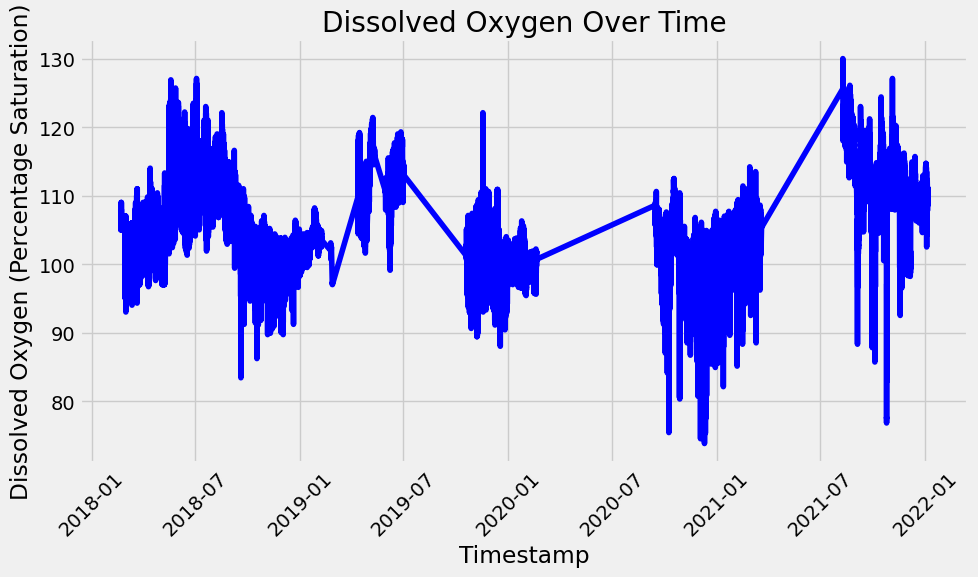

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(df_sorted['TIMESTAMP'], df_sorted['Dissolved Oxygen'] ,linestyle='-', color='blue')
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Dissolved Oxygen (Percentage Saturation)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [18]:
df_sorted

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
2568752,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:01:00,aquaMeasure-670352,108.0,1.80
2568753,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:03:00,aquaMeasure-670353,106.0,1.70
2568755,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:11:00,aquaMeasure-670352,108.0,1.70
2568756,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:13:00,aquaMeasure-670353,106.0,1.70
2568760,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:21:00,aquaMeasure-670352,108.0,1.70
...,...,...,...,...,...,...,...,...
2356674,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:17:00,aquaMeasure-675016,108.7,3.58
2356676,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:27:00,aquaMeasure-675016,110.7,3.54
2356682,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:37:00,aquaMeasure-675016,109.7,3.54
2356688,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:47:00,aquaMeasure-675016,110.3,3.52


In [19]:
df_sorted['TIMESTAMP'] = pd.to_datetime(df_sorted['TIMESTAMP'])

# Set 'TIMESTAMP' as the DataFrame's index
df_sorted.set_index('TIMESTAMP', inplace=True)

# Now, proceed with the resampling as before

# Resample numerical features by mean
df_resampled_num = df_sorted.select_dtypes(include=['float64', 'int64']).resample('30T').mean()

# For categorical features, we'll first use ffill to fill gaps after resampling
df_resampled_cat = df_sorted.select_dtypes(exclude=['float64', 'int64']).resample('30T').first().ffill()

# Combine the resampled numerical and categorical dataframes
df_resampled = pd.concat([df_resampled_num, df_resampled_cat], axis=1)

# Reset index if needed to make 'time_idx' a regular column
df_resampled.reset_index(inplace=True)

# Optionally, if you need to create 'time_idx' as a sequential integer index
df_resampled['time_idx'] = range(len(df_resampled))

warnings.filterwarnings('ignore')

In [20]:
df_resampled['target'] = df_resampled['Dissolved Oxygen'].shift(-48)

In [22]:
# Drop rows with any NaN values
df_resampled_clean = df_resampled.dropna()

# Reset index if needed to make 'TIMESTAMP' a regular column
df_resampled_clean.reset_index(inplace=True)

# Optionally, if you need to create 'time_idx' as a sequential integer index
df_resampled_clean['time_idx'] = range(len(df_resampled_clean))

warnings.filterwarnings('ignore')

In [23]:
df_resampled_clean = df_resampled_clean.sort_values(by='TIMESTAMP')

In [24]:
df_resampled_clean

VARIABLE,index,TIMESTAMP,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target
0,0,2018-02-20 19:00:00,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000
1,1,2018-02-20 19:30:00,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000
2,2,2018-02-20 20:00:00,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000
3,3,2018-02-20 20:30:00,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333
4,4,2018-02-20 21:00:00,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000
...,...,...,...,...,...,...,...,...,...,...,...
40120,67853,2022-01-04 09:30:00,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40120,110.466667
40121,67854,2022-01-04 10:00:00,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,40121,110.566667
40122,67855,2022-01-04 10:30:00,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40122,109.833333
40123,67856,2022-01-04 11:00:00,44.817926,-62.61883,111.266667,3.246667,Spry Bay,Spry Harbour,aquaMeasure-675016,40123,109.300000


In [25]:
def identify_gaps(dataframe, threshold_hours=6):
    # Assuming 'TIMESTAMP' is a column in the dataframe, we'll ensure it's in datetime format
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['TIMESTAMP'])
    time_diff = dataframe['TIMESTAMP'].diff()
    gaps = time_diff > pd.Timedelta(hours=threshold_hours)
    return gaps

# Identify gaps
df_resampled_clean['gap'] = identify_gaps(df_resampled_clean)

# List to store the start and end datetimes of each gap
gap_ranges = []

# Identifying the start and end datetime of gap periods
for index, row in df_resampled_clean.iterrows():
    if row['gap']:
        start_gap_datetime = df_resampled_clean.iloc[max(0, index - 1)]['TIMESTAMP']
        end_gap_datetime = row['TIMESTAMP']
        gap_ranges.append((start_gap_datetime, end_gap_datetime))

In [26]:
df_resampled = df_resampled_clean

In [27]:
df_resampled['TIMESTAMP'] = pd.to_datetime(df_resampled['TIMESTAMP'])
df_resampled.set_index('TIMESTAMP', inplace=True)

In [28]:
df_resampled['gap'] = False

# Adjust gap_ranges to include 24 hours before and after each gap
extended_gap_ranges = []
for start, end in gap_ranges:
    extended_start = start - pd.Timedelta(hours=24)
    extended_end = end + pd.Timedelta(hours=24)
    extended_gap_ranges.append((extended_start, extended_end))

# Mark resampled data as gap based on extended_gap_ranges
for start, end in extended_gap_ranges:
    df_resampled.loc[start:end, 'gap'] = True

# Now, filter out the rows marked as gaps
df_resampled = df_resampled[df_resampled['gap'] == False]

# Drop the 'gap' column as it's no longer needed after filtering
df_resampled = df_resampled.drop('gap', axis=1)

In [29]:
df_resampled

VARIABLE,index,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target
TIMESTAMP,,,,,,,,,,
2018-02-20 19:00:00,0,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000
2018-02-20 19:30:00,1,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000
2018-02-20 20:00:00,2,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000
2018-02-20 20:30:00,3,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333
2018-02-20 21:00:00,4,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-04 09:30:00,67853,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40120,110.466667
2022-01-04 10:00:00,67854,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,40121,110.566667
2022-01-04 10:30:00,67855,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40122,109.833333


In [30]:
df_resampled_clean = df_resampled

In [31]:
df_resampled_clean.reset_index(inplace=True)

# Ensure TIMESTAMP is in datetime format
df_resampled_clean['TIMESTAMP'] = pd.to_datetime(df_resampled_clean['TIMESTAMP'])

# Create 'day', 'month', and 'hour' features from the TIMESTAMP column
df_resampled_clean['day'] = df_resampled_clean['TIMESTAMP'].dt.day.astype(str)
df_resampled_clean['month'] = df_resampled_clean['TIMESTAMP'].dt.month.astype(str)
df_resampled_clean['hour'] = df_resampled_clean['TIMESTAMP'].dt.hour.astype(str)

# Create or update 'time_idx' to be a sequential integer index starting from 0
df_resampled_clean['time_idx'] = range(len(df_resampled_clean))

In [50]:
def build_continuous_features_report(data_df):

    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [51]:
build_continuous_features_report(df_resampled_clean)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
VARIABLE,,,,,,,,,,
index,39408,0.0,39408,0.000000,9989.750000,31391.431105,31025.500000,51007.250000,67857.000000,22477.655106
LATITUDE,39408,0.0,653,44.501170,44.722883,44.769876,44.817926,44.838540,44.876550,0.096050
LONGITUDE,39408,0.0,648,-63.956720,-63.064010,-62.842991,-62.618830,-62.511840,-62.400250,0.442362
Dissolved Oxygen,39408,0.0,8306,75.933333,100.533333,104.973303,103.233333,109.500000,125.900000,6.019632
Temperature,39408,0.0,18920,-1.033333,3.275288,7.885617,6.808167,11.630000,20.526667,5.370763
time_idx,39408,0.0,39408,0.000000,9851.750000,19703.500000,19703.500000,29555.250000,39407.000000,11376.254041
target,39408,0.0,8306,75.933333,100.527778,104.953086,103.233333,109.433333,125.900000,6.006699


In [52]:
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [53]:
build_categorical_features_report(df_resampled_clean)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
VARIABLE,,,,,,,,,
TIMESTAMP,39408,0.0,39408,"[2018-02-20 19:00:00, 2018-02-20 19:30:00, 201...",39408,100.000000,[],0,0.000000
WATERBODY,39408,0.0,8,[Spry Bay],11782,29.897483,[Beaver Harbour],7877,19.988327
STATION,39408,0.0,8,[Spry Harbour],11782,29.897483,[Beaver Point],7877,19.988327
SENSOR,39408,0.0,18,[aquaMeasure-675016],10152,25.761267,[aquaMeasure-670362],4736,12.017864
day,39408,0.0,31,[3],1369,3.473914,[2],1363,3.458689
month,39408,0.0,12,[12],5952,15.103532,[11],5760,14.616322
hour,39408,0.0,24,[22],1654,4.197117,"[1, 13]",3296,8.363784


#Data Preperation

In [32]:
df_resampled_clean

VARIABLE,TIMESTAMP,index,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target,day,month,hour
0,2018-02-20 19:00:00,0,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000,20,2,19
1,2018-02-20 19:30:00,1,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000,20,2,19
2,2018-02-20 20:00:00,2,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000,20,2,20
3,2018-02-20 20:30:00,3,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333,20,2,20
4,2018-02-20 21:00:00,4,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000,20,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,2022-01-04 09:30:00,67853,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39403,110.466667,4,1,9
39404,2022-01-04 10:00:00,67854,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,39404,110.566667,4,1,10
39405,2022-01-04 10:30:00,67855,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39405,109.833333,4,1,10
39406,2022-01-04 11:00:00,67856,44.817926,-62.61883,111.266667,3.246667,Spry Bay,Spry Harbour,aquaMeasure-675016,39406,109.300000,4,1,11


## Modelling

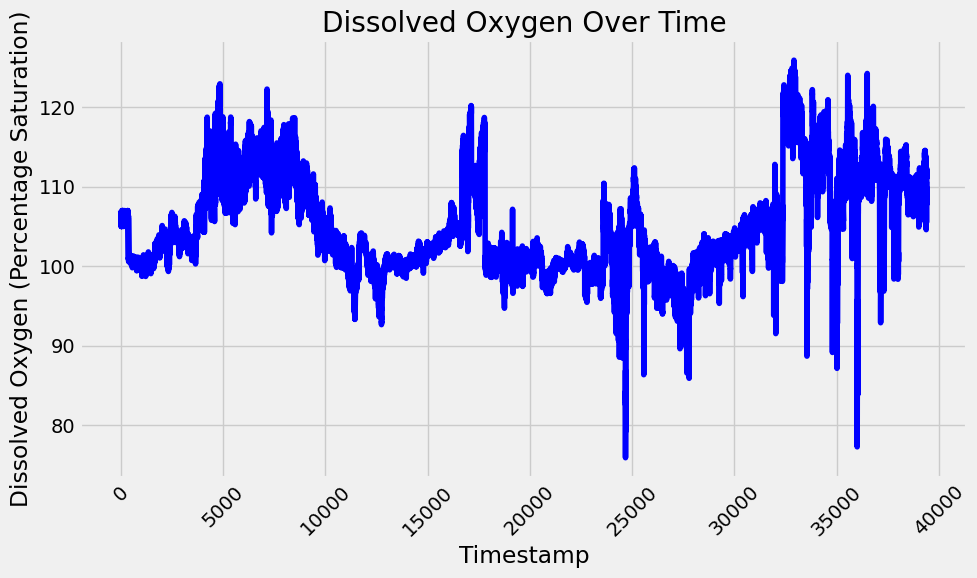

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(df_resampled_clean['time_idx'], df_resampled_clean['Dissolved Oxygen'] ,linestyle='-', color='blue')
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Dissolved Oxygen (Percentage Saturation)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [34]:
data = df_resampled_clean

In [35]:
total_rows = len(data)
train_end = int(total_rows * 0.7)

df = data.iloc[:train_end]

testing_data = data.iloc[train_end:]


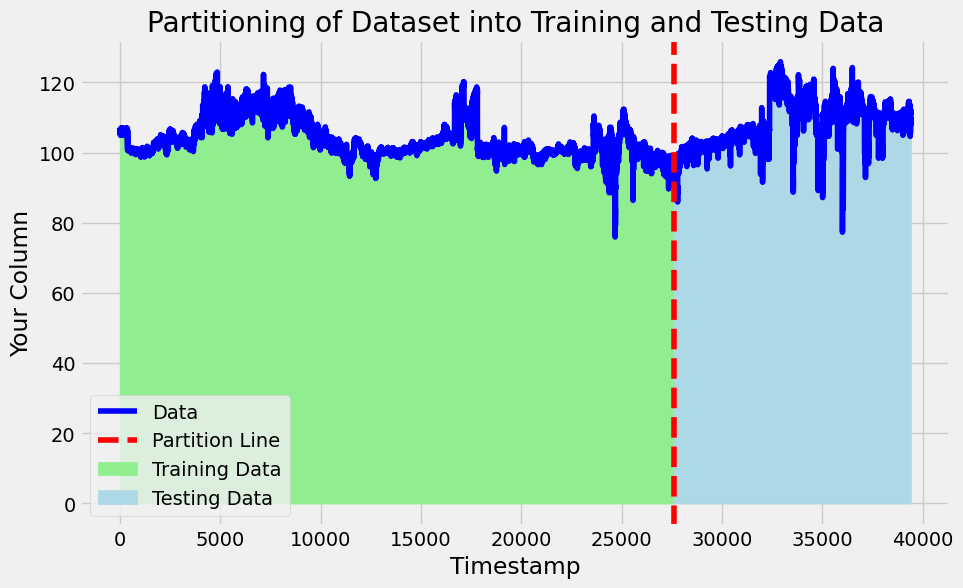

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Dissolved Oxygen'], color='blue', label='Data')
plt.axvline(x=data.index[train_end], color='red', linestyle='--', label='Partition Line')
plt.fill_between(data.index[:train_end], data['Dissolved Oxygen'][:train_end], color='lightgreen', label='Training Data')
plt.fill_between(data.index[train_end:], data['Dissolved Oxygen'][train_end:], color='lightblue', label='Testing Data')
plt.xlabel('Timestamp')
plt.ylabel('Your Column')
plt.title('Partitioning of Dataset into Training and Testing Data')
plt.legend()
plt.show()


In [37]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

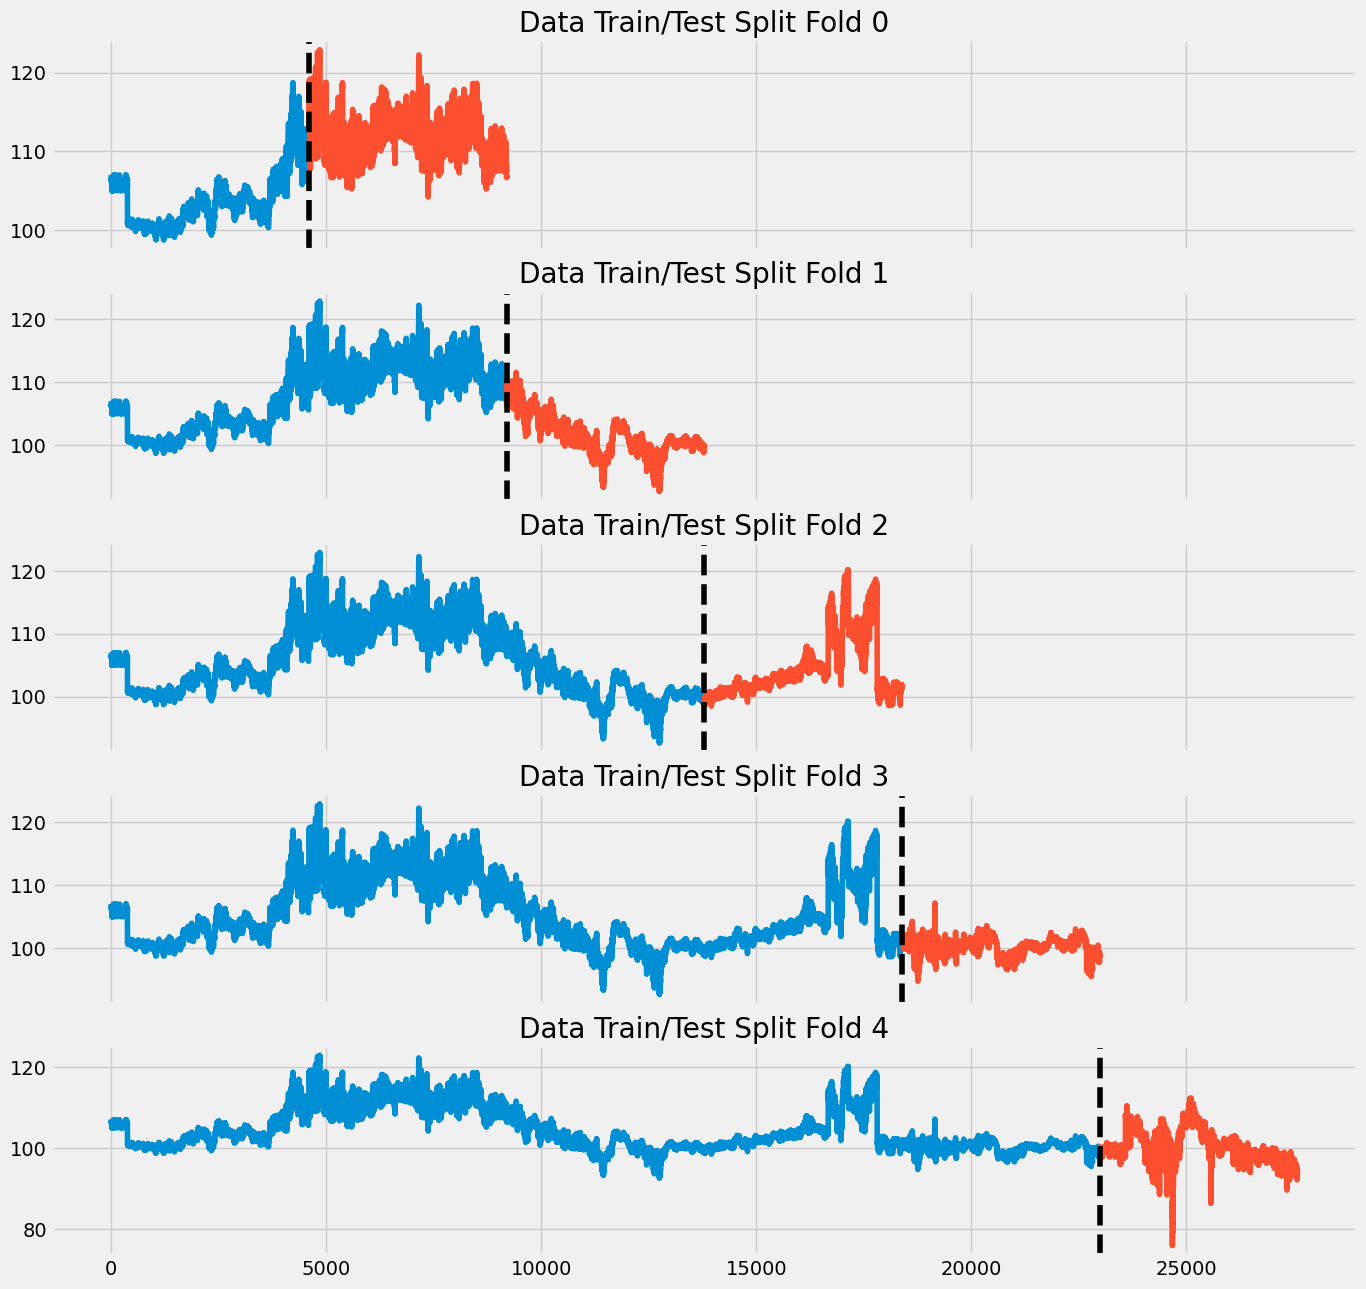

In [38]:
from sklearn.model_selection import TimeSeriesSplit
tss=TimeSeriesSplit(n_splits=5,  gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Dissolved Oxygen'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Dissolved Oxygen'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [39]:
df.columns



Index(['TIMESTAMP', 'index', 'LATITUDE', 'LONGITUDE', 'Dissolved Oxygen',
       'Temperature', 'WATERBODY', 'STATION', 'SENSOR', 'time_idx', 'target',
       'day', 'month', 'hour'],
      dtype='object', name='VARIABLE')

In [40]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# Extract relevant datetime features
df['year'] = df['TIMESTAMP'].dt.year
df['month'] = df['TIMESTAMP'].dt.month
df['day'] = df['TIMESTAMP'].dt.day
df['dayofweek'] = df['TIMESTAMP'].dt.dayofweek
df['hour'] = df['TIMESTAMP'].dt.hour

In [41]:
tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]



    FEATURES = ['year', 'month', 'day', 'dayofweek', 'hour']
    TARGET = 'Dissolved Oxygen'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    warnings.filterwarnings('ignore')

[0]	validation_0-rmse:102.22774	validation_1-rmse:110.09498
[100]	validation_0-rmse:37.48303	validation_1-rmse:43.31562
[200]	validation_0-rmse:13.78587	validation_1-rmse:19.15353
[300]	validation_0-rmse:5.15021	validation_1-rmse:10.64231
[400]	validation_0-rmse:2.09895	validation_1-rmse:7.72180
[500]	validation_0-rmse:1.17669	validation_1-rmse:6.75455
[600]	validation_0-rmse:0.95577	validation_1-rmse:6.41817
[700]	validation_0-rmse:0.89598	validation_1-rmse:6.29710
[800]	validation_0-rmse:0.86292	validation_1-rmse:6.25286
[900]	validation_0-rmse:0.84070	validation_1-rmse:6.23507
[992]	validation_0-rmse:0.80747	validation_1-rmse:6.23984
[0]	validation_0-rmse:106.21493	validation_1-rmse:100.03717
[100]	validation_0-rmse:38.95270	validation_1-rmse:30.42922
[200]	validation_0-rmse:14.37013	validation_1-rmse:5.65127
[290]	validation_0-rmse:6.02304	validation_1-rmse:4.76557
[0]	validation_0-rmse:104.24092	validation_1-rmse:103.15069
[100]	validation_0-rmse:38.24415	validation_1-rmse:38.6089

In [42]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.7410
Fold scores:[6.23337084569702, 3.2468436289866083, 3.2506605359241423, 1.9667339371756378, 4.007297339246647]


In [46]:
testing_data['year'] = testing_data['TIMESTAMP'].dt.year
testing_data['month'] = testing_data['TIMESTAMP'].dt.month
testing_data['day'] = testing_data['TIMESTAMP'].dt.day
testing_data['hour'] = testing_data['TIMESTAMP'].dt.hour
testing_data['dayofweek'] = testing_data['TIMESTAMP'].dt.dayofweek


# Define features and target variable
FEATURES = ['year', 'month', 'day', 'dayofweek', 'hour']
TARGET = 'Dissolved Oxygen'

# Extract features and target variable from testing_data
X_test = testing_data[FEATURES]
y_test = testing_data[TARGET]

# Make predictions using the trained XGBoost model
y_pred = reg.predict(X_test)



warnings.filterwarnings('ignore')

In [47]:
from sklearn.metrics import mean_absolute_error

# Assuming y_test contains the actual values and y_pred contains the predicted values
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 7.447322199777904


In [48]:
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 8.830470813105551


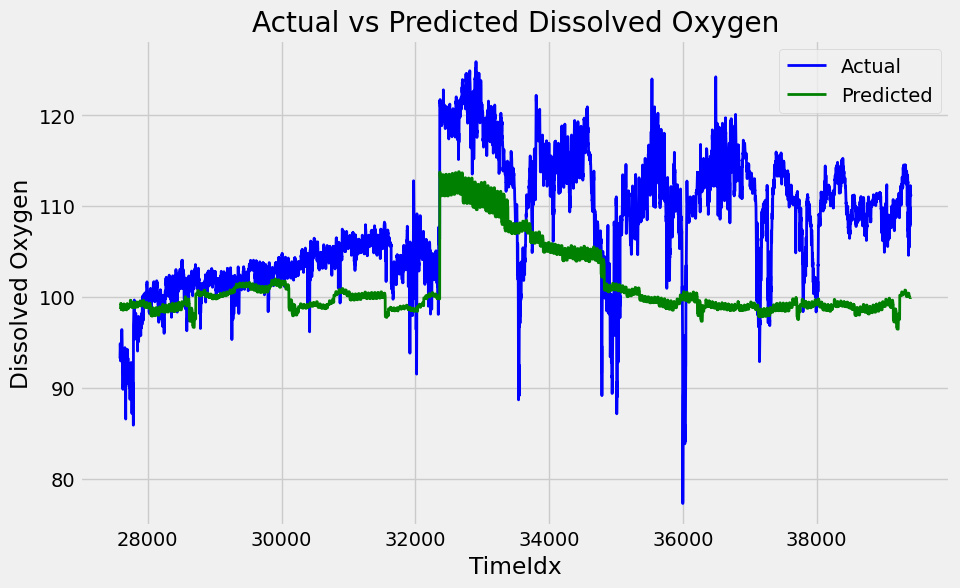

In [49]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(testing_data.index, y_test, label='Actual', color='blue', linewidth=2)
plt.plot(testing_data.index, y_pred, label='Predicted', color='green', linewidth=2)
plt.title('Actual vs Predicted Dissolved Oxygen')
plt.xlabel('TimeIdx')
plt.ylabel('Dissolved Oxygen')
plt.legend()
plt.grid(True)
plt.show()
